In [1]:
import os
import urllib.request 
import pandas as pd


In [2]:
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

In [3]:
fetch_titanic_data()

In [4]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [5]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Let's look at each of these attributes and document my first thoughts about these attributes:

Pclass: reflects social hierarchy , might have an affect on who is saved, and who is not<br>
Name: shouldn't have any impact<br>
Sex: Females are more likely preferred over males, so i think this is an important predictor<br> 
Age: It could also have an impact. For e.g. children might have been preferred over adults <br>
SibSp: It might have an impact. For e.g. if there is a couple, they are more likely to have survived or not
Parch: Similar reasoning as above. 
Tikcet: This won't have any impact
Fare: Higher fare may reflect the social status, and it might have an impact on who survived 
Cabin: Same as above
Embarked: Can't think how this can have an impact on survival. 

In [9]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

In [10]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
#checking if my inital hypothesis of ticket price paid a role in survival by checking the survivial status of the
# most expensive ticket.

train_data[train_data["Fare"]==512.329200]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [12]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [13]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [14]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [15]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64


Let's start with building the pipeline for the numerical attributes first

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

Now the pipeline for the categorical attributes 

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False))  
])

In [19]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [20]:
X_train = preprocess_pipeline.fit_transform(train_data[num_attribs + cat_attribs])
X_train.shape, X_train

((891, 12),
 array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
          0.        ,  1.        ],
        [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
          0.        ,  0.        ],
        [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
          0.        ,  1.        ],
        [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
          1.        ,  0.        ]]))

In [21]:
y_train = train_data["Survived"]
y_train.shape

(891,)

Let's start with a RandomForestClassifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [30]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

In [32]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

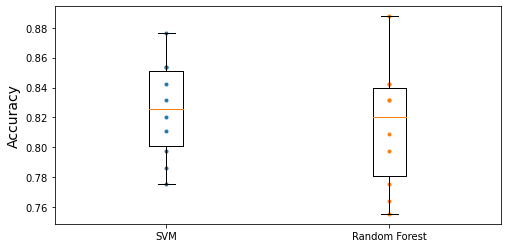

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()